In [81]:
import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
import optax
from IPython.display import Image, display
from ipywidgets import HBox, Image as WidgetImage, Layout
import pandas as pd

#### IT3105 – Artificial Intelligence Programming; Introductory Project
# General Purpose JAX-based PID Controllers
##### Sindre Grodås Standal Aas og Elias Lerheim Birkeland

______

## Controller Class
The Controller class should take the error –– from running one time step –– as input, and then output a controll signal.
The error consists of the current difference between target state and actual state, the sum of all previous errors of the time steps in one epoch, and the change in error from last time step. It should also have an update function, where you can update the weights after each epoch.

In [82]:
def display_images(filenames):
    widgets = []
    # Load images as widgets
   
    for images in filenames:
        image = WidgetImage(value=open(images, 'rb').read(), format='jpeg', width=700)
        widgets.append(image)

    # Display images side by side using HBox
    display(HBox(widgets))
display_images(['standard_PID.jpeg', 'nn_PID.jpeg'])

In [83]:
class Controller:

    def __init__(self):
        pass

    def controll_signal(self, current_E, sum_E, dE):
        pass

    def update(self):
        pass

class StandardController(Controller):
    def __init__(self, k_p=0.1, k_i=0.3, k_d=0.1):
        self.k_p = k_p
        self.k_i = k_i
        self.k_d = k_d
        super().__init__()

    def controll_signal(self, current_E, sum_E, dE):
        return self.k_p * current_E + self.k_d * dE + self.k_i * sum_E
    
    def updateWeights(self, weights):
        self.k_p, self.k_i, self.k_d = weights[0], weights[1], weights[2]
        return
    
    def getWeights(self):
        return [self.k_p, self.k_i, self.k_d]
    

def custom_uniform_init(minval=-0.1, maxval=0.1):
    """
    A custom uniform initializer with specified min and max values.
    """
    def init(key, shape, dtype=jnp.float32):
        return jax.random.uniform(key, shape, minval=minval, maxval=maxval, dtype=dtype)
    return init

class NeuralController(nn.Module):
    num_layers: int
    neurons_per_layer: list
    activation: str
    init_minval: float
    init_maxval: float

    @nn.compact
    def __call__(self, x):
        # Use the custom uniform initializer
        uniform_init = custom_uniform_init(self.init_minval, self.init_maxval)
        
        for i, neurons in enumerate(self.neurons_per_layer):
            x = nn.Dense(neurons, kernel_init=uniform_init, bias_init=uniform_init)(x)
            if i < len(self.neurons_per_layer) - 1:
                if self.activation == 'relu':
                    x = nn.relu(x)
                elif self.activation == 'sigmoid':
                    x = nn.sigmoid(x)
                else:
                    x = nn.tanh(x)
        return x


## Plant Class

In [84]:
class Plant:

    def __init__(self):
        pass

    def update_state(self, controll_signal, noise):
        pass

    def output(self, controll_signal, noise):
        pass

class BathtubPlant(Plant):

    def __init__(self, A, C, h0, g=9.81):

        self.A = A
        self.C = C
        self.h0 = h0
        self.h = h0
        self.g = g
        super().__init__()


    
    def Q(self, current_h):
        # Compute flow rate Q based on the current height
        return self.C * jnp.sqrt(2 * self.g * current_h)
    
    def dB(self, controll_signal, noise):
        return controll_signal + noise - self.Q()
    
    def dh(self, controll_signal, noise, current_h):
        # Compute the change in height based on the current height, not self.h
        new_h = current_h + (controll_signal + noise - self.Q(current_h)) / self.A
        return new_h
    

class CournotPlant:
    def __init__(self, pmax, mc, q1_initial=0.1, q2_initial=0.3, target_profit=0.6):
        self.pmax = pmax
        self.mc = mc
        self.q1 = q1_initial
        self.q2 = q2_initial
        self.target_profit = target_profit

    def simulate_step(self, control_signal, noise, current_q1, current_q2):
        new_q1 = max(current_q1 + control_signal, 0)
        new_q2 = current_q2 + noise
        new_profit = self.profit(new_q1, new_q2)
        error = self.target_profit - new_profit
        return new_q1, new_q2, error, new_profit

    def profit(self, q1, q2):
        q_total = q1 + q2
        price = max(self.pmax - q_total, 0)
        return q1 * (price - self.mc)


    

## Pivotal Parameters

In [85]:
#display_images(['pivotal_params.jpeg'])

In [86]:
PLANT_TYPE = 'cournot'  # {'bathtub', 'cournot', 'rabbits'}
CONTROLLER_TYPE = 'nn' # {'standard', 'nn'}
KP = 0.1
KI = 0.1
KD = 0.1
NUM_LAYERS = 3 # [0,5]
NUM_NEURONS = [128, 64, 1] # one int per layer in NUM_LAYERS
ACTIVATION_FUNC = 'relu' # {'relu', 'tanh', 'sigmoid'}
INITIAL_VALUES_RANGE = [-0.1, 0.1]

NUM_EPOCHS = 100
NUM_TIMESTEPS = 10
LEARNING_RATE = 0.001
NOISE_RANGE = [-0.01, 0.01]

A = 10.0
C = A / 100
H0 = 10.0

PMAX = 1.0
MC = 0.1
TARGET_PROFIT = 0.6
INITIAL_Q1 = 0.1
INITIAL_Q2 = 0.1

# Configure System

In [87]:
class Consys():

    def __init__(self,
                 plant_type=PLANT_TYPE, controller_type=CONTROLLER_TYPE, num_layers=NUM_LAYERS, num_neurons = NUM_NEURONS, activation_func=ACTIVATION_FUNC, initial_values_range=INITIAL_VALUES_RANGE,
                 num_epochs=NUM_EPOCHS, num_timesteps=NUM_TIMESTEPS, learning_rate=LEARNING_RATE, noise_range=NOISE_RANGE,
                 A=A, C=C, h0=H0,
                 pmax=PMAX, MC=MC
                   ):
        
        self.plant_type = plant_type
        self.controller_type = controller_type
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        self.activation_function = activation_func
        self.initial_values_range = initial_values_range
        self.num_epochs = num_epochs
        self.num_timesteps = num_timesteps
        self.learning_rate = learning_rate
        self.noise_range = noise_range
        self.A=A
        self.C=C
        self.h0=h0
        self.pmax=pmax
        self.MC=MC

        if self.plant_type == 'bathtub':
            self.plant = BathtubPlant(self.A, self.C, self.h0)
        
        elif self.plant_type == 'cournot':
            self.plant = CournotPlant(pmax=self.pmax, mc=self.MC, target_profit=TARGET_PROFIT, q1_initial=INITIAL_Q1, q2_initial=INITIAL_Q2)

        else:
            pass # Add last plant

        if self.controller_type == 'standard':
            self.controller = StandardController(k_p=KP, k_i=KI, k_d=KD)
        
        else:
            self.controller = NeuralController(num_layers=NUM_LAYERS,
                                               neurons_per_layer=NUM_NEURONS,
                                               activation='relu',
                                               init_minval=INITIAL_VALUES_RANGE[0],
                                               init_maxval=INITIAL_VALUES_RANGE[1]
                                               )
            
            # Initialize and apply the model
            key = jax.random.PRNGKey(9)
            x = jnp.ones((1, 3))  
            self.controller.params = self.controller.init(key, x) ["params"]  # Model initialization

    

    def run_timesteps(self, params, key, noise_array):
        
        error_history = []

        if self.plant_type == 'bathtub':
            current_h = self.plant.h0  # Initialize the water height
            
            for t in range(self.num_timesteps):
                key, subkey = jax.random.split(key)  # Split the key for this timestep
                #noise = jax.random.uniform(subkey, minval=self.noise_range[0], maxval=self.noise_range[1], shape=())
                noise = noise_array[t]
                
                if self.controller_type == 'standard':
                    self.controller.updateWeights(params)
                    # Compute the control signal based on the error, which might be the difference from a target height
                    error = self.plant.h0 - current_h  # Example error computation
                    control_signal = self.controller.controll_signal(error, sum(error_history), error - error_history[-1] if error_history else 0)

                    # Update the height based on the control signal and noise
                    current_h = self.plant.dh(control_signal, noise, current_h)

                    # Store the error for use in the next timestep
                    error_history.append(error)
                else:
                    # NeuralController logic
                    prev_error = error_history[-1] if error_history else 0.0
                    sum_error = jnp.sum(jnp.array(error_history)) if error_history else 0.0
                    current_error = self.plant.h0 - current_h  # This is your error term, for example
                    
                    # Prepare the input for the neural network controller
                    nn_input = jnp.array([[current_error, sum_error, current_error - prev_error]])
                    control_signal = self.controller.apply({'params': params}, nn_input).squeeze()
                    
                    # Update plant's state with the control signal and noise
                    current_h = self.plant.dh(control_signal, noise, current_h)
                    
                    # Store the current error for use in the next timestep
                    error_history.append(current_error)
        
        if self.plant_type == 'cournot':
            current_q1 = self.plant.q1
            current_q2 = self.plant.q2

            for t in range(self.num_timesteps):
                key, subkey = jax.random.split(key)
                #noise = jax.random.uniform(subkey, minval=self.noise_range[0], maxval=self.noise_range[1])
                noise = noise_array[t]

                if self.controller_type == 'standard':
                    self.controller.updateWeights(params)

                    # For example, with a standard controller:
                    error = self.plant.target_profit - self.plant.profit(current_q1, current_q2)
                    control_signal = self.controller.controll_signal(error, sum(error_history), error - error_history[-1] if error_history else 0)

                    
                    new_q1, new_q2, error, _ = self.plant.simulate_step(control_signal, noise, current_q1, current_q2)
                    current_q1, current_q2 = new_q1, new_q2  # Update plant state here

                    error_history.append(error)

                else:
                   # NeuralController logic
                    prev_error = error_history[-1] if error_history else 0.0
                    sum_error = jnp.sum(jnp.array(error_history)) if error_history else 0.0
                    current_error = self.plant.target_profit - self.plant.profit(current_q1, current_q2)
                    
                    # Prepare the input for the neural network controller
                    nn_input = jnp.array([[current_error, sum_error, current_error - prev_error]])
                    control_signal = self.controller.apply({'params': params}, nn_input).squeeze()
                    
                    new_q1, new_q2, error, _ = self.plant.simulate_step(control_signal, noise, current_q1, current_q2)
                    current_q1, current_q2 = new_q1, new_q2  # Update plant state here

                    error_history.append(error)

        
        # Calculate the mean squared error over all timesteps as the loss
        loss = jnp.mean(jnp.square(jnp.array(error_history)))
        return loss


    

    def run_epochs(self):
        mse_history = []
        pid_history = []
        key = jax.random.PRNGKey(5)  # Initialize your PRNG key here
        

        if self.controller_type == 'standard':
            differentiables = self.controller.getWeights()  # Initial weights
            
            for e in range(self.num_epochs):
                noise_array = np.random.uniform(self.noise_range[0], self.noise_range[1], self.num_timesteps)
                # Use `value_and_grad` to get both the loss (MSE) and its gradients
                mse_computation = lambda p: self.run_timesteps(p, key, noise_array)  # Adjust `run_timesteps` to accept `key`
                loss, grads = jax.value_and_grad(mse_computation)(differentiables)

                # Update weights based on gradients
                # This is a simplified update rule, consider using an optimizer for more complex scenarios
                differentiables = [w - self.learning_rate * g for w, g in zip(differentiables, grads)]
                
                # Update the controller's weights after each epoch
                self.controller.updateWeights(differentiables)
                
                #print(f"Epoch {e}, Loss: {loss}, Grads: {grads}")

                # Optionally, you can track and return the MSE history for analysis
                mse_history.append(loss)
                pid_history.append(self.controller.getWeights())

            return np.array(mse_history), np.array(pid_history)
        
        else:
            
            # Neural controller training
            optimizer = optax.adam(self.learning_rate)
            params = self.controller.params
            opt_state = optimizer.init(params)

            for e in range(self.num_epochs):
                noise_array = np.random.uniform(self.noise_range[0], self.noise_range[1], self.num_timesteps)
                # Define the loss function for neural controller based on simulation
                def loss_fn(params):
                    return self.run_timesteps(params, key, noise_array)

                # Compute gradients and update parameters
                grads = jax.grad(loss_fn)(params)
                updates, opt_state = optimizer.update(grads, opt_state)
                params = optax.apply_updates(params, updates)

                # Optional: Recompute loss for logging
                loss = loss_fn(params)
                mse_history.append(loss)
                #print(f"Epoch {e}, Loss: {loss}")
                
            return np.array(mse_history)



# Visualization
Change the constants in the pivotal parameters section in order to test out different controllers in different systems.

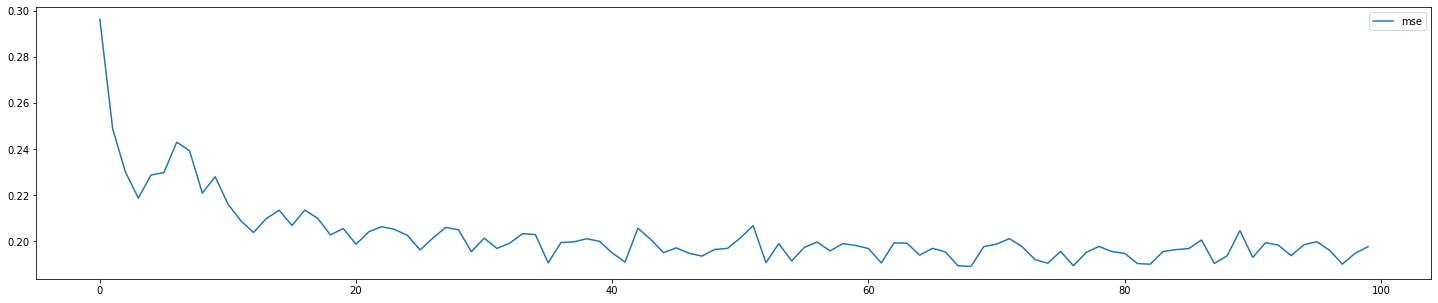

In [88]:
system = Consys()

if system.controller_type == 'standard':
    mse_history, pid_history = system.run_epochs()
    mse_df = pd.DataFrame(mse_history, columns=['mse'])
    pid_df = pd.DataFrame(pid_history, columns=['kp','ki','kd'])
    pid_df.plot(y=['kp','ki','kd'], figsize=(25, 5))
    mse_df.plot(y=['mse'], figsize=(25, 5))
else:
    mse_history = system.run_epochs()
    mse_df = pd.DataFrame(mse_history, columns=['mse'])
    mse_df.plot(y=['mse'], figsize=(25, 5))
